In [15]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%time
# ~18mins

# Execute CURATE without pop tau
execute_CURATE()

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

In [3]:
%%time
df = pd.read_excel('output (with pop tau by LOOCV).xlsx', sheet_name='result')

Wall time: 30.5 s


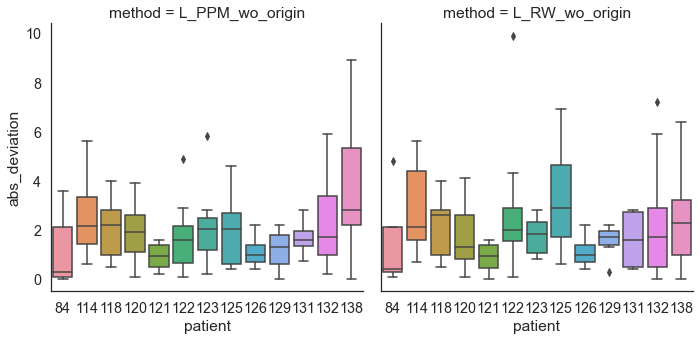

In [19]:
dat = df.copy()
dat.columns

# Subset the 2 top methods
dat = dat[(dat.method=='L_RW_wo_origin') | (dat.method=='L_PPM_wo_origin')]

median = dat.groupby(['method', 'patient'])['abs_deviation'].median().reset_index()

# median

sns.set(font_scale=1.3, style='white')
sns.catplot(data=dat, x='patient', y='abs_deviation', col='method', kind='box')

In [23]:
df = CURATE_could_be_useful()

In [110]:
dat = df.copy()

# Create column for adapted within range to indicate if data point
# could have been within range if augmented by CURATE
dat['adapted_within_range'] = dat.within_range

dat = dat.reset_index()

for i in range(len(dat)):
    if (dat.within_range[i]==False and dat.CURATE_could_be_useful[i]==True):
        if dat.method[i] == 'L_PPM_wo_origin':
            dat.loc[i, 'adapted_within_range'] = 'Potentially True with CURATE_PPM'
        else: 
            dat.loc[i, 'adapted_within_range'] = 'Potentially True with CURATE_RW'
    

# Subset columns for combining dataframe for plotting and
# rearrange for unstacking
dat = dat[['pred_day', 'patient', 'method', 'adapted_within_range']]
dat = dat.set_index(['pred_day', 'patient', 'method'])

# Unstack
dat = dat.unstack().reset_index()

# Rename columns
dat.columns = ['day', 'patient', 'PPM', 'RW']

# Add new column for adapted_within_range
dat['adapted_within_range'] = ""
dat['PPM'] = dat['PPM'].astype("string")
dat['RW'] = dat['RW'].astype("string")
for i in range(len(dat)):
    
    if ('Potential' in dat.PPM[i]) and ('Potential' in dat.RW[i]):
        dat.loc[i, 'adapted_within_range'] = 'potentially_true_PPM_RW'
    elif ('Potential' in dat.PPM[i]):
        dat.loc[i, 'adapted_within_range'] = 'potentially_true_PPM'
    elif ('Potential' in dat.RW[i]):
        dat.loc[i, 'adapted_within_range'] = 'potentially_true_RW'
    else: # if no CURATE augmentation, take PPM's within range column as reference
        dat.loc[i, 'adapted_within_range'] = 'CURATE_not_helpful'

# Only keep those that CURATE could outperform SOC
dat = dat[dat.adapted_within_range != 'CURATE_not_helpful']

dat

# Merge this dataframe with the one with the plots!!!
    
        
# dat.PPM

,day,patient,PPM,RW,adapted_within_range
0,3,123,Potentially True with CURATE_PPM,False,potentially_true_PPM
1,4,84,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
3,4,120,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
5,5,84,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
7,5,120,False,Potentially True with CURATE_RW,potentially_true_RW
9,5,131,False,Potentially True with CURATE_RW,potentially_true_RW
11,6,118,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
20,7,121,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
28,8,118,Potentially True with CURATE_PPM,Potentially True with CURATE_RW,potentially_true_PPM_RW
32,8,123,False,Potentially True with CURATE_RW,potentially_true_RW
